# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources (README.md file)
- Happy learning!

In [17]:
import pandas as pd
import numpy as np

import datetime
from dateutil.relativedelta import relativedelta

# Viz mantra
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%config Inlinebackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16., 9.)})
sns.set_style('whitegrid')

import plotly.express as px
import plotly.graph_objects as go

# Statsmodel
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose


# Scikit learn
from sklearn.linear_model import LinearRegression


# Challenge 1 - Loading and Evaluating The Data

In this lab, we will look at a dataset of sensor data from a cellular phone. The phone was carried in the subject's pocket for a few minutes while they walked around.

To load the data, run the code below.

In [2]:
# Run this code:

sensor = pd.read_csv('../sub_1.csv')
sensor.drop(columns=['Unnamed: 0'], inplace=True)

Examine the data using the `head` function.

In [3]:
sensor.head()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542
1,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866
2,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808
3,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958
4,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299


Check whether there is any missing data. If there is any missing data, remove the rows containing missing data.

In [5]:
sensor.isna().sum()


attitude.roll         0
attitude.pitch        0
attitude.yaw          0
gravity.x             0
gravity.y             0
gravity.z             0
rotationRate.x        0
rotationRate.y        0
rotationRate.z        0
userAcceleration.x    0
userAcceleration.y    0
userAcceleration.z    0
dtype: int64

How many rows and columns are in our data?

In [6]:
sensor.shape


(1751, 12)

To perform time series analysis on the data, we must change the index from a range index to a time series index. In the cell below, create a time series index using the `pd.date_range` function. Create a time series index starting at 1/1/2018 00:00:00 and ending at 1/1/2018 00:29:10. The number of periods is equal to the number of rows in `sensor`. The frequency should be set to `infer`.

In [34]:
sensor.set_index(pd.date_range(start= '1/1/2018 00:00:00',
                  end='1/1/2018 00:29:10',
                 periods=len(sensor)), inplace=True)

#sensor.index.freq = pd.infer_freq(sensor)
sensor.sample()


,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
2018-01-01 00:03:41,1.520333,-0.898381,-2.294691,0.622084,0.78232,-0.031419,-0.11734,-0.100087,-1.039305,0.474565,0.123534,-0.098723


Assign the time series index to the dataframe's index.

In [42]:
sensor.index.freq = 'S'


Our next step is to decompose the time series and evaluate the patterns in the data. Load the `statsmodels.api` submodule and plot the decomposed plot of `userAcceleration.x`. Set `freq=60` in the `seasonal_decompose` function. Your graph should look like the one below.

![time series decomposition](../images/tsa_decompose.png)

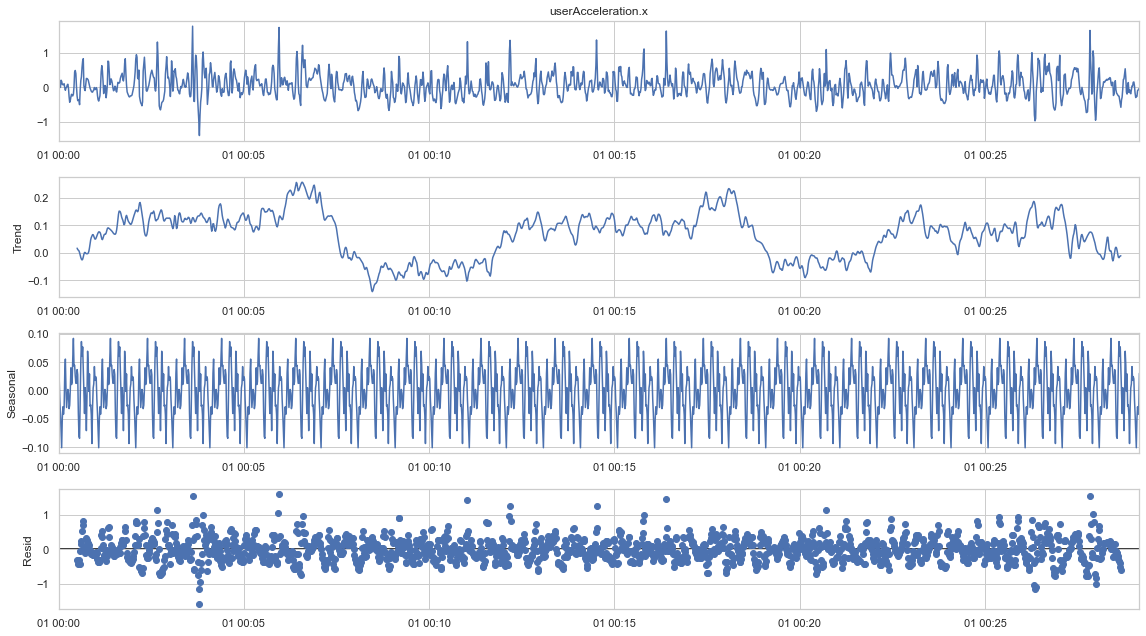

In [78]:
res = seasonal_decompose(sensor['userAcceleration.x'], model="additive", period = 60)
res.plot();


Plot the decomposed time series of `rotationRate.x` also with a frequency of 60.

# Challenge 2 - Modelling the Data

To model our data, we should look at a few assumptions. First, let's plot the `lag_plot` to detect any autocorrelation. Do this for `userAcceleration.x`

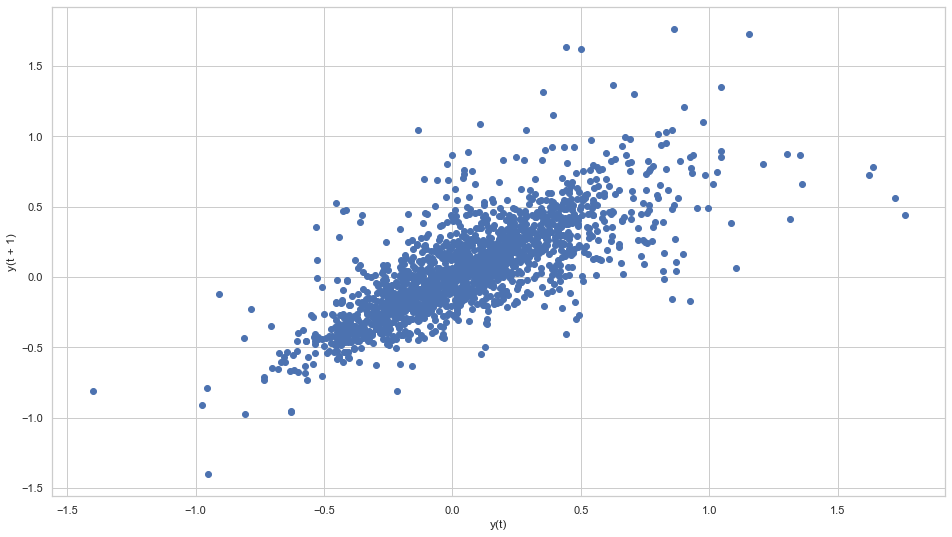

In [80]:
pd.plotting.lag_plot(sensor['userAcceleration.x'], lag=1);


Create a lag plot for `rotationRate.x`

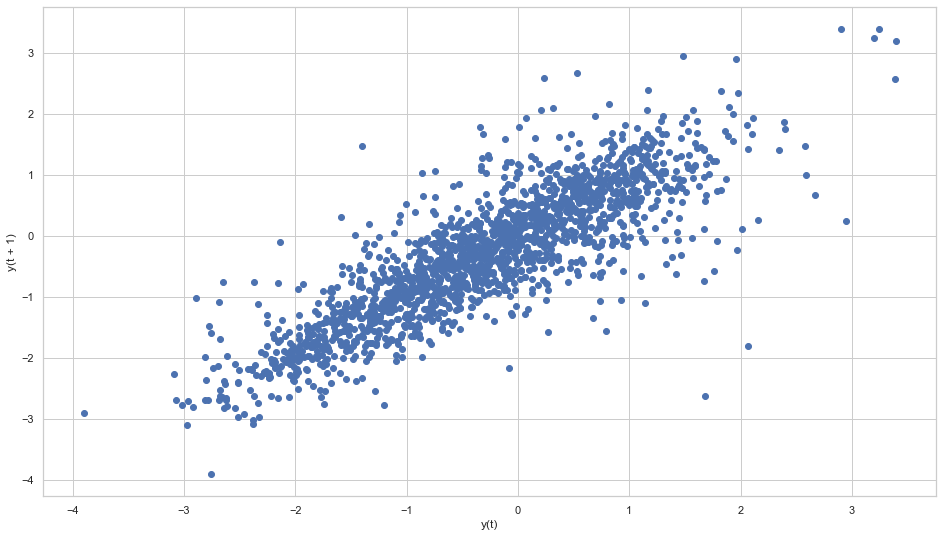

In [81]:
pd.plotting.lag_plot(sensor['rotationRate.x'], lag=1);



What are your conclusions from both visualizations?

In [11]:
# Your conclusions here:



The next step will be to test both variables for stationarity. Perform the Augmented Dickey Fuller test on both variables below.

In [82]:
# 𝐻0 (Null Hypothesis) : The series is not stationary and there is a statistically significant trend
#𝐻𝐴 (Alternative hypothesis) : The series is stationary
from statsmodels.tsa.stattools import adfuller

res = adfuller(sensor["userAcceleration.x"])
res[1]

# It's stationary

2.823439483037483e-30

In [86]:
res = adfuller(sensor["rotationRate.x"])
res[1]

# It's stationary

6.320230335912605e-06

What are your conclusions from this test?

In [13]:
# Your conclusions here:



## Bonus: Challenge 2

Finally, we'll create an ARIMA model for `userAcceleration.x`. Load the `ARIMA` function from `statsmodels`. The order of the model is (2, 0, 1). Split the data to train and test. Use the last 10 observations as the test set and all other observations as the training set. 

In [87]:
order = (2, 0, 1)

In [88]:
# 0. Splitting into train & test
y_train = sensor["userAcceleration.x"][:-10]
y_test = sensor["userAcceleration.x"][-11:]

In [89]:
# 1. Create an instance of the ARIMA model that takes y_train, the order, and freq="S"
# Docs: https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html
from statsmodels.tsa.arima.model import ARIMA



In [94]:
model = ARIMA(y_train, order = order, freq="S").fit()
model

In [109]:
# 3. Predict: create y_pred:
sensor["y_pred"] = model.predict(start=len(y_train), end=len(sensor))
sensor

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,y_pred
2018-01-01 00:00:00,1.528132,-0.733896,0.696372,0.741895,0.669768,-0.031672,0.316738,0.778180,1.082764,0.294894,-0.184493,0.377542,NaN
2018-01-01 00:00:01,1.527992,-0.716987,0.677762,0.753099,0.657116,-0.032255,0.842032,0.424446,0.643574,0.219405,0.035846,0.114866,NaN
2018-01-01 00:00:02,1.527765,-0.706999,0.670951,0.759611,0.649555,-0.032707,-0.138143,-0.040741,0.343563,0.010714,0.134701,-0.167808,NaN
2018-01-01 00:00:03,1.516768,-0.704678,0.675735,0.760709,0.647788,-0.041140,-0.025005,-1.048717,0.035860,-0.008389,0.136788,0.094958,NaN
2018-01-01 00:00:04,1.493941,-0.703918,0.672994,0.760062,0.647210,-0.058530,0.114253,-0.912890,0.047341,0.199441,0.353996,-0.044299,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 00:29:06,1.797120,-0.562324,2.445889,0.824443,0.533154,0.189844,-0.123211,0.909536,-0.379757,-0.268367,0.006733,-0.064874,0.053770
2018-01-01 00:29:07,1.814297,-0.569719,2.449655,0.817212,0.539396,0.203020,-0.057641,0.723118,-0.437812,-0.102444,-0.060666,-0.229738,0.056783
2018-01-01 00:29:08,1.830821,-0.578367,2.447967,0.809207,0.546658,0.215288,0.343238,0.997236,-0.338155,-0.085590,-0.030209,-0.087740,0.060638
2018-01-01 00:29:09,1.849557,-0.586962,2.439458,0.800485,0.553834,0.229110,0.470144,1.227937,-0.332223,-0.048105,0.029555,0.060441,0.063308


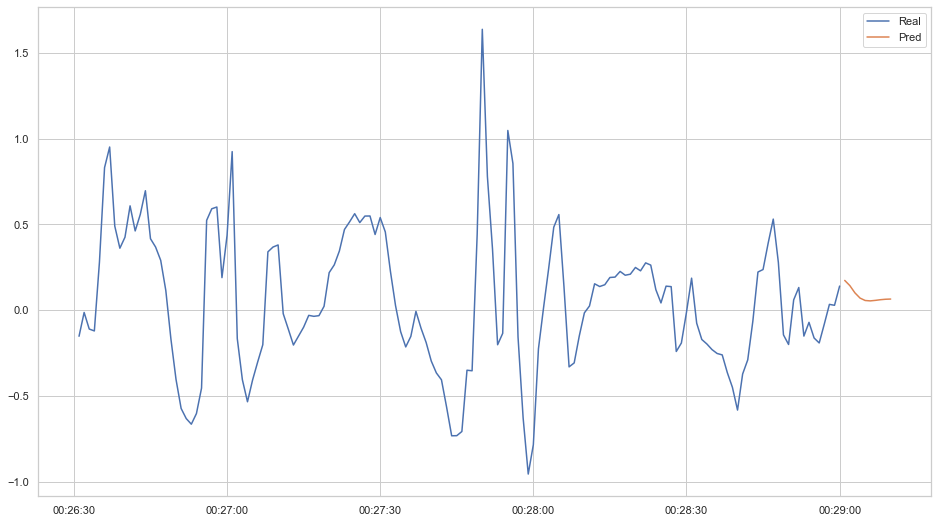

In [112]:
# 4. Visualize
plt.plot(y_train[-150:], label = "Real")
plt.plot(sensor.y_pred, label = "Pred")
plt.legend();

To compare our predictions with the observed data, we can compute the RMSE (Root Mean Squared Error) from the submodule `statsmodels.tools.eval_measures`. You can read more about this function [here](https://www.statsmodels.org/dev/generated/statsmodels.tools.eval_measures.rmse.html). Compute the RMSE for the last 10 rows of the data by comparing the observed and predicted data for the `userAcceleration.x` column.

In [16]:
# Your code here:

# rmse(y_pred, y_test)